# Using parametric pump to improve fidelity of dynamical entanglement


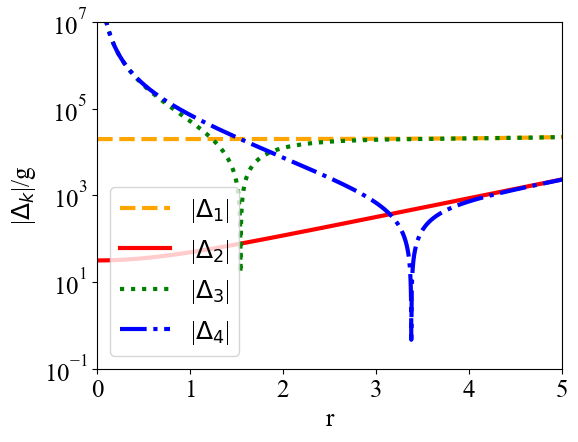

In [121]:
# figure for Delta-r

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# parameters
g = 1 # coupling
kappa = 1 # cavity loss
omega = 10**4 * g # emitter frequency
omega_a = omega + 10**5 * kappa # cavity frequency
C = 10**3   # cooperativity
gamma = g**2 / kappa / C #emitter decay

M = 5000
dr = np.linspace(0.001, 5, M) # squeezing parameter

# calculate
fr = (1 - np.tanh(2*dr)**2)**0.5 
Delta_2 = g * (kappa/gamma)**0.5 * np.cosh(dr) 
omega_p = 2 * (omega + Delta_2 - omega_a * fr) / (1 - fr) # driving frequency
omega_b = (omega_a - omega_p/2) * fr # squeezed cavity frequency
Delta_1 = omega_p/2 + omega_b + omega
Delta_3 = omega_p/2 - omega_b + omega
Delta_4 = omega_p/2 - omega_b - omega

# save the data
np.savetxt('dr_parameter.txt', np.column_stack((dr, abs(Delta_1), abs(Delta_2), abs(Delta_3), abs(Delta_4))), delimiter=' ')

# figure
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot(dr, abs(Delta_1), label='|$\Delta$$_1$|', linewidth=3, linestyle='--', color='orange')  
ax.plot(dr, abs(Delta_2), label='|$\Delta$$_2$|', linewidth=3, linestyle='-', color='r')  
ax.plot(dr, abs(Delta_3), label='|$\Delta$$_3$|', linewidth=3, linestyle=':', color='g')  
ax.plot(dr, abs(Delta_4), label='|$\Delta$$_4$|', linewidth=3, linestyle='-.', color='b')  
plt.yscale('log')
# title, label and scale
ax.axis([0, 5, 10**-1, 10**7])
ax.set_xlabel('r')
ax.set_ylabel('|$\Delta$$_k$|/g')
ax.tick_params(axis='both', which='major')

# legend
plt.legend(loc='best')
plt.show()




In [123]:
# run this unit first. this unit includes all functions that we used.

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# for time dependence
def H1_coeff(t, args): 
    return np.exp(1j * Delta_1 * t)
def H1m_coeff(t, args):        
    return np.exp(-1j * Delta_1 * t)
def H2_coeff(t, args):        
    return np.exp(1j * Delta_2 * t)
def H2m_coeff(t, args):        
    return np.exp(-1j * Delta_2 * t)
def H3_coeff(t, args):        
    return np.exp(1j * Delta_3 * t)
def H3m_coeff(t, args):        
    return np.exp(-1j * Delta_3 * t)
def H4_coeff(t, args):        
    return np.exp(1j * Delta_4 * t)
def H4m_coeff(t, args):        
    return np.exp(-1j * Delta_4 * t)


# Operators for two-level emitters and cavity
N = 2  # Two-level emitter
Na = 16  # Cavity photon number truncation
sigma_1 = tensor(sigmam(), qeye(N), qeye(Na))  # Lowering operator for emitter 1
sigma_2 = tensor(qeye(N), sigmam(), qeye(Na))  # Lowering operator for emitter 2
a = tensor(qeye(N), qeye(N), destroy(Na))  # Photon annihilation operator
S = sigma_1 + sigma_2  # Collective spin operator
N1 = sigma_1.dag() * sigma_1
N2 = sigma_2.dag() * sigma_2

# Initial and target states
psi_0 = tensor(basis(N, 0), basis(N, 1), basis(Na, 0))  # Initial state |100>
phi_1 = (tensor(basis(N, 0), basis(N, 1)) - 1j * tensor(basis(N, 1), basis(N, 0))) / math.sqrt(2)  # Target state 1
phi_2 = (tensor(basis(N, 0), basis(N, 1)) + 1j * tensor(basis(N, 1), basis(N, 0))) / math.sqrt(2)  # Target state 2

# operators and states after tracing the cavity mode
sigma_1_eff = tensor(sigmam(), qeye(N)) # lowering operator for emitter 1
sigma_2_eff = tensor(qeye(N), sigmam()) # lowering operator for emitter 2
N1_eff = sigma_1_eff.dag() * sigma_1_eff
N2_eff = sigma_2_eff.dag() * sigma_2_eff
S_eff = sigma_1_eff + sigma_2_eff # collective operator
psi_0_eff = tensor(basis(N, 0), basis(N, 1))


def dr_dynamics_full():
    global J_2, J_4
    if Delta_4 <= 0:
        T = math.pi / abs(J_2)
    else:
        T = math.pi / abs(J_2 + J_4)
    Nt = int(T * 800)
    times = np.linspace(0, T, Nt)
    H_full = [[gc*a.dag()*S.dag(), H1_coeff],   [gc*a*S, H1m_coeff], 
             [gc*a*S.dag(), H2m_coeff], [gc*a.dag()*S, H2_coeff],
             [-gs*a*S.dag(), H3_coeff],  [-gs*a.dag()*S, H3m_coeff], 
             [-gs*a.dag()*S.dag(), H4m_coeff], [-gs*a*S, H4_coeff]]
    colps_full = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a]
    data_full = mesolve(H_full, psi_0, times, colps_full, [])
    N_aa = [expect(a.dag() * a, state) for state in data_full.states]
    if J_2 + J_4 > 0: # get the entangled state phi_1
        F_full = [fidelity(phi_1, state.ptrace((0, 1))) for state in data_full.states]
    else: # get the entangled state phi_2
        F_full = [fidelity(phi_2, state.ptrace((0, 1))) for state in data_full.states]
    return F_full, N_aa

def dr_dynamics_RWA():
    global J_2, J_4
    if Delta_4 <= 0:
        T = math.pi / abs(J_2)
    else:
        T = math.pi / abs(J_2 + J_4)
    Nt = int(T * 800)
    times = np.linspace(0, T, Nt)
    H_RWA = [[gc*a*S.dag(), H2m_coeff], [gc*a.dag()*S, H2_coeff], 
            [-gs*a.dag()*S.dag(), H4m_coeff], [-gs*a*S, H4_coeff]]
    colps_RWA = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a]
    data_RWA = mesolve(H_RWA, psi_0, times, colps_RWA, [])
    if J_2 + J_4 > 0:
        F_RWA = [fidelity(phi_1, state.ptrace((0, 1))) for state in data_RWA.states]
    else:
        F_RWA = [fidelity(phi_2, state.ptrace((0, 1))) for state in data_RWA.states]
    return F_RWA

def dr_dynamics_eff():
    global J_2, J_4
    if Delta_4 <= 0:
        T = math.pi / abs(J_2)
    else:
        T = math.pi / abs(J_2 + J_4)
    Nt = int(T * 800)
    times = np.linspace(0, T, Nt)
    J_2 = - gc**2 * Delta_2 / (Delta_2**2 + kappa**2/4)
    J_4 = gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)
    Gamma_2 = gc**2 * kappa / (Delta_2**2 + kappa**2/4)
    Gamma_4 = gs**2 * kappa / (Delta_4**2 + kappa**2/4)
    H_eff = J_2 * S_eff.dag() * S_eff + J_4 * S_eff * S_eff.dag()
    colps_eff =[math.sqrt(gamma) * sigma_1_eff, math.sqrt(gamma) * sigma_2_eff, math.sqrt(Gamma_2) * S_eff, math.sqrt(Gamma_4) * S_eff.dag()]
    data_eff = mesolve(H_eff, psi_0_eff, times, colps_eff, [])
    if J_2 + J_4 > 0:
        F_eff = [fidelity(phi_1, state) for state in data_eff.states]
    else:
        F_eff = [fidelity(phi_2, state) for state in data_eff.states]
    return F_eff

# if only H_2 works
def dr_dynamics_H2():
    global J_2, J_4
    T = math.pi / abs(J_2)
    Nt = int(T * 800)
    times = np.linspace(0, T, Nt)
    H_2 = [[gc*a*S.dag(), H2m_coeff], [gc*a.dag()*S, H2_coeff]]
    colps_H2 = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a]
    data_H2 = mesolve(H_2, psi_0, times, colps_H2, [])
    F_H2 = [fidelity(phi_2, state.ptrace((0, 1))) for state in data_H2.states]
    return F_H2

# if only H_4 works
def dr_dynamics_H4():
    global J_2, J_4
    T = math.pi / abs(J_4)
    Nt = int(T * 800)
    times = np.linspace(0, T, Nt)
    H_4 = [[-gs*a.dag()*S.dag(), H4m_coeff], [-gs*a*S, H4_coeff]]
    colps_H4 = [math.sqrt(gamma) * sigma_1, math.sqrt(gamma) * sigma_2, math.sqrt(kappa) * a]
    data_H4 = mesolve(H_4, psi_0, times, colps_H4, [])
    if J_4 > 0:
        F_H4 = [fidelity(phi_1, state.ptrace((0, 1))) for state in data_H4.states]
    else:
        F_H4 = [fidelity(phi_2, state.ptrace((0, 1))) for state in data_H4.states]
    return F_H4

print('Functions are ready')


Functions are ready


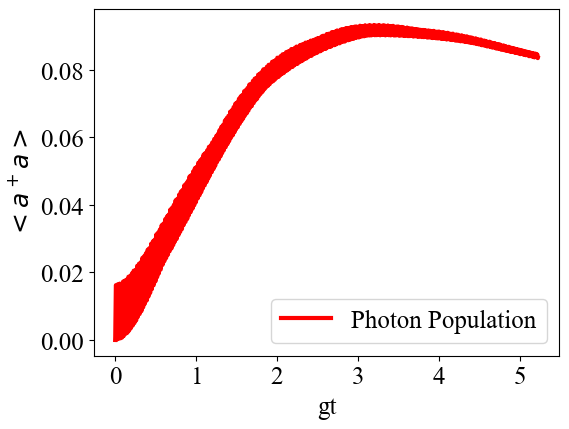

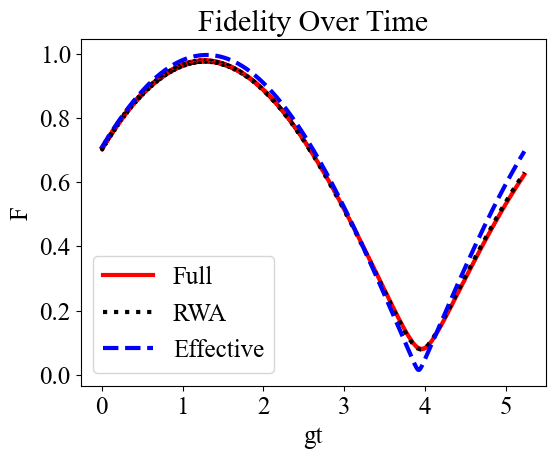

Running time: 126.74 s


In [106]:
# the dynamics of fidelity

# Start timing
start_time = time.time()


# parameter
r = 3.602 # squeezing parameter, r=3.602 is the position of strange peak
g = 1 # coupling
kappa = g # cavity decay
omega = 10**4 * g # emitter frequency
omega_a = omega + 10**5 * kappa # cavity frequency
C = 10**3 # cooperativity
gamma = g**2 / kappa / C # emitter decay
gc = g * np.cosh(r)
gs = g * np.sinh(r)
fr = (1- np.tanh(2*r)**2)**0.5
Delta_2 = g * (kappa/gamma)**0.5 * np.cosh(r) 
omega_p = 2 * (omega + Delta_2 - omega_a * fr) / (1 - fr) 
omega_b = (omega_a - omega_p/2) * fr
Delta_1 = omega_p/2 + omega_b + omega
#Delta_2 = omega_p/2 + omega_b - omega
Delta_3 = omega_p/2 - omega_b + omega
Delta_4 = omega_p/2 - omega_b - omega
J_2 = - gc**2 * Delta_2 / (Delta_2**2 + kappa**2/4)
J_4 = gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)

if Delta_4 <= 0:
    T = math.pi / abs(J_2)
else:
    T = math.pi / abs(J_2 + J_4)
Nt = int(T * 800)
times = np.linspace(0, T, Nt)

# Calculate dynamics using the global parameter setup
F_full, N_aa = dr_dynamics_full()  # Full dynamics calculation
F_RWA = dr_dynamics_RWA()  # Effective dynamics calculation
F_eff = dr_dynamics_eff()  # Effective dynamics calculation


# Plotting results
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))
plt.plot(times, N_aa, label='Photon Population', linewidth=3, linestyle='-', color='red')
plt.xlabel('gt')
plt.ylabel('$<a^+a>$')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(6, 4.5))
plt.plot(times, F_full, label='Full', linewidth=3, linestyle='-', color='red')
plt.plot(times, F_RWA, label='RWA', linewidth=3, linestyle=':', color='black')
plt.plot(times, F_eff, label='Effective', linewidth=3, linestyle='--', color='blue')
plt.title('Fidelity Over Time')
plt.xlabel('gt')
plt.ylabel('F')
plt.legend(loc='best')
plt.show()

# save the data
np.savetxt('dr_F_t.txt', np.column_stack((times, F_full, F_RWA, F_eff)), delimiter=' ')

# End timing and print the execution time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")

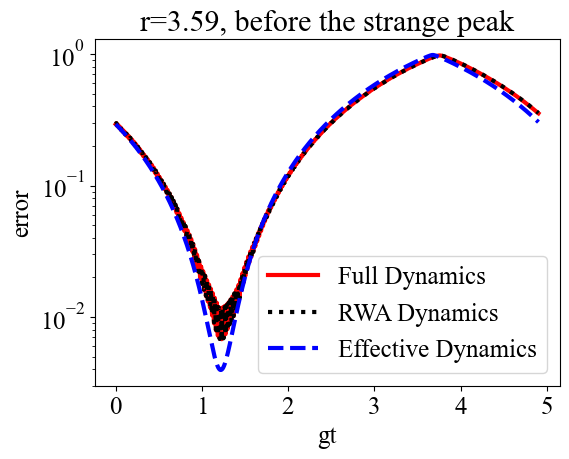

In [29]:
# notice that there is a strange peak around r=3.6. 
# therefore we show the dynamics around the peak to compare
# for r=3.59, before the strange peak
plt.figure(figsize=(6, 4.5))
plt.plot(times, 1 - np.array(F_full), label='Full Dynamics', linewidth=3, linestyle='-', color='red')
plt.plot(times, 1 - np.array(F_RWA), label='RWA Dynamics', linewidth=3, linestyle=':', color='black')
plt.plot(times, 1 - np.array(F_eff), label='Effective Dynamics', linewidth=3, linestyle='--', color='blue')
plt.title('r=3.59, before the strange peak')
plt.xlabel('gt')
plt.ylabel('error')
plt.legend(loc='best')
plt.yscale('log')
plt.show()

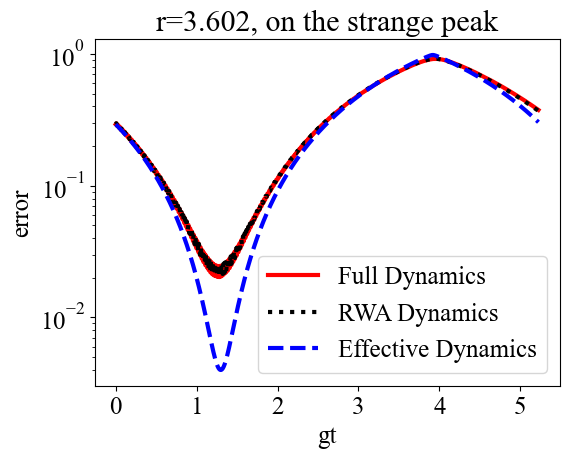

In [33]:
# notice that there is a strange peak around r=3.6. 
# therefore we show the dynamics around the peak to compare
# for r=3.602, before the strange peak

plt.figure(figsize=(6, 4.5))
plt.plot(times, 1 - np.array(F_full), label='Full Dynamics', linewidth=3, linestyle='-', color='red')
plt.plot(times, 1 - np.array(F_RWA), label='RWA Dynamics', linewidth=3, linestyle=':', color='black')
plt.plot(times, 1 - np.array(F_eff), label='Effective Dynamics', linewidth=3, linestyle='--', color='blue')
plt.title('r=3.602, on the strange peak')
plt.xlabel('gt')
plt.ylabel('error')
plt.legend(loc='best')
plt.yscale('log')
plt.show()

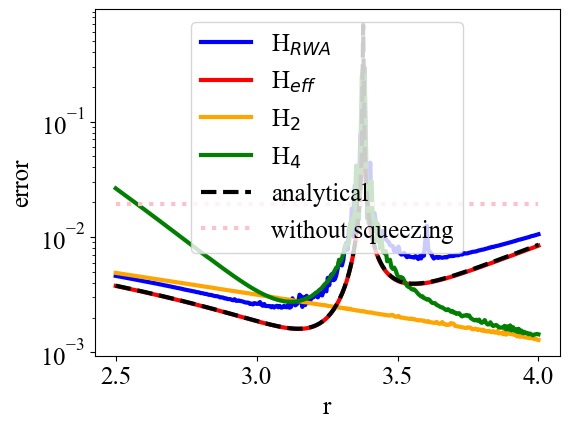

Running time: 6510.56 s


In [136]:
# error versus r
# this unit costs a long time
# Start timing
start_time = time.time()


# parameter
g = 1 # coupling
kappa = g # cavity decay
omega = 10**4 * g # emitter frequency
omega_a = omega + 10**5 * kappa # cavity frequency
C = 10**3 # cooperativity
gamma = g**2 / kappa / C # emitter decay
M = 300
dr = np.linspace(2.5, 4, M)

# array for saving data
epsilon_RWA = np.zeros(M)
epsilon_eff = np.zeros(M)
epsilon_H2 = np.zeros(M)
epsilon_H4 = np.zeros(M)
epsilon_ana = np.zeros(M)
epsilon_C = np.linspace(1, 1, M) * (3 / 8 / C)**0.5 # without squeezing



for i in range (M):
    # parameters
    r = dr[i]
    gc = g * np.cosh(r)
    gs = g * np.sinh(r)
    fr = (1- np.tanh(2*r)**2)**0.5
    Delta_2 = g * (kappa/gamma)**0.5 * np.cosh(r) 
    omega_p = 2 * (omega + Delta_2 - omega_a * fr) / (1 - fr) 
    omega_b = (omega_a - omega_p/2) * fr
    Delta_1 = omega_p/2 + omega_b + omega
    #Delta_2 = omega_p/2 + omega_b - omega
    Delta_3 = omega_p/2 - omega_b + omega
    Delta_4 = omega_p/2 - omega_b - omega
    J_2 = - gc**2 * Delta_2 / (Delta_2**2 + kappa**2/4)
    J_4 = gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)
    Gamma_2 = gc**2 * kappa / (Delta_2**2 + kappa**2/4)
    Gamma_4 = gs**2 * kappa / (Delta_4**2 + kappa**2/4)
    
    # solve master equation
    epsilon_RWA[i] = 1 - np.max(dr_dynamics_RWA())
    epsilon_eff[i] = 1 - np.max(dr_dynamics_eff())
    epsilon_H2[i] = 1 - np.max(dr_dynamics_H2())
    epsilon_H4[i] = 1 - np.max(dr_dynamics_H4())
    epsilon_ana[i] = 0.5 * math.pi / (4 * abs(J_2 + J_4)) * (gamma + Gamma_2 + Gamma_4)



# Plotting results
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
plt.figure(figsize=(6, 4.5))
plt.plot(dr, epsilon_RWA, label='H$_{RWA}$', linewidth=3, linestyle='-', color='blue')
plt.plot(dr, epsilon_eff, label='H$_{eff}$', linewidth=3, linestyle='-', color='red')
plt.plot(dr, epsilon_H2, label='H$_2$', linewidth=3, linestyle='-', color='orange')
plt.plot(dr, epsilon_H4, label='H$_4$', linewidth=3, linestyle='-', color='green')
plt.plot(dr, epsilon_ana, label='analytical', linewidth=3, linestyle='--', color='black')
plt.plot(dr, epsilon_C, label='without squeezing', linewidth=3, linestyle=':', color='pink')
plt.xlabel('r')
plt.ylabel('error')
plt.legend(loc='best')
plt.yscale('log')
plt.show()

# save the data
np.savetxt('dr_F_r.txt', np.column_stack((dr, epsilon_RWA, epsilon_eff, epsilon_H2, epsilon_H4, epsilon_ana, epsilon_C)), delimiter=' ')

# End timing and print the execution time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")

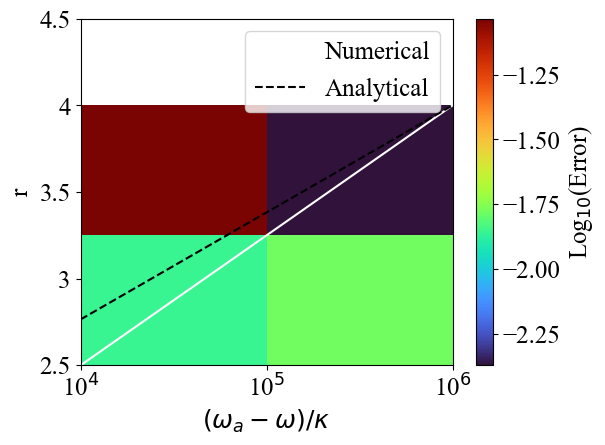

Running time: 17.92 s


In [81]:
# the error versus squeezing r and (omega_a-omega)/kappa
# this unit costs a long time

# Start timing
start_time = time.time()


# parameter
g = 1
kappa = g # cavity decay
omega = g * 10**4 # emitter frequency
C = 10**2
gamma = g**2 / kappa / C
M = 200
dr = np.linspace(2.5, 4, M)
log_domega_a = np.linspace(4, 6, M) # = log10[(omega_a - omega) / kappa]
_domega_a = np.power(10, log_domega_a) # = (omega_a - omega) / kappa
epsilon_RWA = np.zeros((M, M))

# numerical solution
for j in range (M):
    #parameters
    r = dr[j]
    gc = g * np.cosh(r)
    gs = g * np.sinh(r)
    fr = (1- np.tanh(2*r)**2)**0.5
    Delta_2 = g * (kappa/gamma)**0.5 * np.cosh(r)
    for k in range (M):
        omega_a = omega + kappa * _domega_a[k]
        omega_p = 2 * (omega + Delta_2 - omega_a * fr) / (1 - fr) 
        omega_b = (omega_a - omega_p/2) * fr
        Delta_1 = omega_p/2 + omega_b + omega
        Delta_2 = omega_p/2 + omega_b - omega
        Delta_3 = omega_p/2 - omega_b + omega
        Delta_4 = omega_p/2 - omega_b - omega
        J_2 = - gc**2 * Delta_2 / (Delta_2**2 + kappa**2/4)
        J_4 = gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)
        epsilon_RWA[j][k] = 1 - np.max(dr_dynamics_RWA()) # solve
        
# Analytical solution
r_ana = np.log(4 * _domega_a / C**0.5) / 3
r_ana = np.clip(r_ana, None, dr[-1])  # Ensure values do not exceed the plot range
# Numerical solution for optimal r
r_num = dr[np.argmin(epsilon_RWA, axis=0)]


# plot
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
fig, ax = plt.subplots(figsize=(6, 4.5))
heatmap = ax.imshow(np.log10(epsilon_RWA), extent=[log_domega_a[0], log_domega_a[-1], dr[0], dr[-1]], origin='lower', aspect='auto', cmap='turbo')
plt.colorbar(heatmap, label='Log$_{10}$(Error)')
ax.plot(log_domega_a, r_num, 'w-', label='Numerical')
ax.plot(log_domega_a, r_ana, 'k--', label='Analytical')
ax.legend(loc='best')
ax.set_xlabel('$(\omega_a-\omega)/\kappa$')
ax.set_ylabel('r')
x_ticks = [4, 5, 6]
x_ticks_label = ['10$^4$', '10$^5$', '10$^6$']
y_ticks = [2.5, 3, 3.5, 4, 4.5]
y_ticks_label = y_ticks
plt.xticks(x_ticks, x_ticks_label)#, fontdict={'family': 'Times New Roman'})
plt.yticks(y_ticks, y_ticks_label)#, fontdict={'family': 'Times New Roman'})
# save figure
plt.savefig('dr_error_r_omegaa.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()



# save data in .txt file
combined_array = np.zeros((M+1, M+1))
combined_array[1:, 0] = dr
combined_array[0, 1:] = log_domega_a
combined_array[1:, 1:] = epsilon_RWA
np.savetxt('dr_error_r_omegaa.txt', combined_array, delimiter=' ')

# End timing and print the execution time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")

In [ ]:
# the error versus squeezing r and cooperativity C
# this unit costs a long time

# Start timing
start_time = time.time()


# parameter
g = 1
kappa = g # cavity decay
omega = g * 10**4 # emitter frequency
omega_a = omega + 10**5 * kappa
M = 2
dr = np.linspace(2.5, 4, M)
log_dC = np.linspace(2, 4, M) # = log10(C)
dC = np.power(10, log_dC)
epsilon_RWA = np.zeros((M, M))


for j in range (M):
    #parameters
    r = dr[j]
    gc = g * np.cosh(r)
    gs = g * np.sinh(r)
    fr = (1- np.tanh(2*r)**2)**0.5
    for k in range (M):
        C = dC[k]
        gamma = g**2 / kappa / C
        Delta_2 = g * (kappa/gamma)**0.5 * np.cosh(r)
        omega_p = 2 * (omega + Delta_2 - omega_a * fr) / (1 - fr) 
        omega_b = (omega_a - omega_p/2) * fr
        Delta_1 = omega_p/2 + omega_b + omega
        #Delta_2 = omega_p/2 + omega_b - omega
        Delta_3 = omega_p/2 - omega_b + omega
        Delta_4 = omega_p/2 - omega_b - omega
        J_2 = - gc**2 * Delta_2 / (Delta_2**2 + kappa**2/4)
        J_4 = gs**2 * Delta_4 / (Delta_4**2 + kappa**2/4)
        # solve the master equation
        epsilon_RWA[j][k] = 1 - np.max(dr_dynamics_RWA())
        
# Analytical solution
r_ana = 1 / 3 * np.log(4 * (omega_a - omega) / kappa / dC**0.5)
r_ana = np.clip(r_ana, None, dr[-1])  # Ensure values do not exceed the plot range
# Numerical solution for optimal r
r_num = dr[np.argmin(epsilon_RWA, axis=0)]


# plot
plt.rcParams.update({'font.size': 18, 'font.family': 'Times New Roman'})
fig, ax = plt.subplots(figsize=(6, 4.5))
heatmap = ax.imshow(np.log10(epsilon_RWA), extent=[log_dC[0], log_dC[-1], dr[0], dr[-1]], origin='lower', aspect='auto', cmap='turbo')
plt.colorbar(heatmap, label='Log$_{10}$(Error)')
ax.plot(log_dC, r_num, 'w-', label='Numerical')
ax.plot(log_dC, r_ana, 'k--', label='Analytical')
ax.legend(loc='best')
ax.set_xlabel('C')
ax.set_ylabel('r')
x_ticks = [2, 3, 4]
x_ticks_label = ['10$^2$', '10$^3$', '10$^4$']
y_ticks = [2.5, 3, 3.5, 4]
y_ticks_label = y_ticks
plt.xticks(x_ticks, x_ticks_label)#, fontdict={'family': 'Times New Roman'})
plt.yticks(y_ticks, y_ticks_label)#, fontdict={'family': 'Times New Roman'})
# Save the plot as a PDF file before showing it
plt.savefig('dr_error_r_C.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()





# 创建一个全零的 (N+1)×(N+1) 的二维数组
combined_array = np.zeros((M+1, M+1))
combined_array[1:, 0] = dr
combined_array[0, 1:] = dC
combined_array[1:, 1:] = epsilon_RWA
np.savetxt('dr_error_r_C.txt', combined_array, delimiter=' ')

# End timing and print the execution time
execution_time = time.time() - start_time
print(f"Running time: {execution_time:.2f} s")